In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.optimizers as optimizers

import sys
sys.path.append("..")

from models.regression_model import DemoRegressionDGP
from likelihoods import Gaussian
from utils_training_demo import MCEM_demo, MCEM_windows_demo, MCEM_sampler_demo, MCEM_Q_maximizer_demo

from matplotlib import pyplot as plt

In [3]:
def get_step_data(num_training, num_testing, std_noise=0.01, gap=0.1):
    num_low = num_training // 2
    num_high = num_training - num_low
    X_train = np.vstack((np.linspace(-1.5, -gap/2.0, num_low)[:, np.newaxis],
              np.linspace(gap/2.0, 1.5, num_high)[:, np.newaxis]))
    y = np.vstack((np.zeros((num_low, 1)), np.ones((num_high,1))))
    scale = np.sqrt(y.var())
    offset = y.mean()
    Y_train = (y-offset)/scale*0.5

    X_test = np.linspace(-3., 3., num_testing)[:, None]
    Y_test = np.vstack((np.zeros((num_testing//2, 1)), np.ones((num_testing-num_testing//2,1))))
    Y_test = (Y_test - offset)/scale*0.5
    return np.float32(X_train), np.float32(Y_train), np.float32(X_test), np.float32(Y_test)

def load_demo_data(num_training, num_testing, batch_size, gap=0.1, std_noise=0.01):
    X_train, Y_train, X_test, Y_test= get_step_data(num_training, num_testing, gap=gap, std_noise=std_noise)
    ds_X_train = tf.data.Dataset.from_tensor_slices(X_train)
    ds_Y_train = tf.data.Dataset.from_tensor_slices(Y_train)
    ds_train = tf.data.Dataset.zip((ds_X_train, ds_Y_train))
    ds_X_test = tf.data.Dataset.from_tensor_slices(X_test)
    ds_Y_test = tf.data.Dataset.from_tensor_slices(Y_test)
    ds_test = tf.data.Dataset.zip((ds_X_test, ds_Y_test))

    ds_train = ds_train.shuffle(num_training)
    # ds_test = ds_test.shuffle(num_testing)
    ds_train = ds_train.batch(batch_size) # try not to use full data as one batch
    ds_test = ds_test.batch(num_testing)
    return ds_train, ds_test, X_test

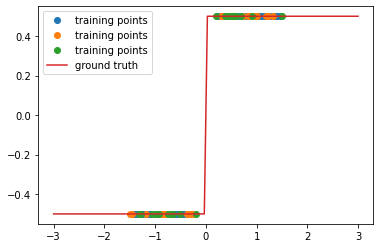

In [4]:
num_training = 60
batch_size = 20
num_testing = 100
gap = 0.4
std_noise = 0.1

ds_train, ds_test, X_test = load_demo_data(num_training, num_testing, batch_size, gap=gap, std_noise=std_noise)
for x, y in ds_train:
    plt.plot(x[:,0], y[:,0], 'o',linewidth=0.5, label='training points')
for x, y in ds_test:
    plt.plot(x[:,0], y[:,0], label='ground truth')
plt.legend()

# 2-layer DGPs (MCEM)

In [5]:
# initialize the model
d_in = 1
d_out = 1
model = DemoRegressionDGP(d_in, d_out, n_hidden_layers=2, n_rf=100, n_gp=1,
                          likelihood=Gaussian(variance=0.01, trainable=True),
                          kernel_type_list=['RBF' for i in range(2)], kernel_trainable=True,
                          random_fixed=True, input_cat=False)

In [6]:
model.Omega_hyperparams

2022-08-25 08:10:39.095822: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


[<tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [9]:
# EM sampler settings
lr_mcmc_0 = 0.01
sampler_EM = MCEM_sampler_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                               lr_0=lr_mcmc_0, momentum_decay=0.95, resample_in_cycle_head=False,
                               start_sampling_epoch=500, epochs_per_cycle=50)

# Maximizer setttings
lr_maximizer = 0.01
optimizer = optimizers.Adam(learning_rate=lr_maximizer)
maximizer = MCEM_Q_maximizer_demo(model, num_training, optimizer)

# sampler settings after fixing hyper-params
lr_fixing_hyper_0 = 0.01
sampler_fixing_hyper = MCEM_sampler_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                                         lr_0=lr_fixing_hyper_0, momentum_decay=0.95, resample_in_cycle_head=False,
                                         start_sampling_epoch=1000, epochs_per_cycle=50)

In [ ]:
# MCEM settings and training
total_EM_steps = 100
_, _, lines, W = MCEM_demo(sampler_EM, maximizer, sampler_fixing_hyper, total_EM_steps, ds_train, 
                      num_samples_EM=10, num_samples_fixing_hyper=100,
                      print_epoch_cycle_EM=100, print_epoch_cycle_fixing=100)

############### EM step 1 of total 100 steps. E Step:  ###############


2022-08-25 08:12:22.810072: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-25 08:12:23.400432: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-08-25 08:12:23.400489: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Sampling Epoch: 99
Mean Log Likelihood -- train: -7.072976589202881, -- test: -24.773157119750977 
Root Mean Squared Error -- train: 0.41125717759132385, -- test: 0.7232814431190491 

Sampling Epoch: 199
Mean Log Likelihood -- train: -7.10526704788208, -- test: -27.11935806274414 
Root Mean Squared Error -- train: 0.4120416045188904, -- test: 0.755023181438446 

Sampling Epoch: 299
Mean Log Likelihood -- train: -7.369865417480469, -- test: -20.421611785888672 
Root Mean Squared Error -- train: 0.418413907289505, -- test: 0.6603825688362122 

Sampling Epoch: 399
Mean Log Likelihood -- train: -7.205226898193359, -- test: -22.394174575805664 
Root Mean Squared Error -- train: 0.4144604802131653, -- test: 0.6896059513092041 

Sampling Epoch: 499
Mean Log Likelihood -- train: -7.057804107666016, -- test: -26.62289810180664 
Root Mean Squared Error -- train: 0.41088807582855225, -- test: 0.748418927192688 

#################### Sample No.1 at Epoch 549  lr = 6.087738091409278e-10 ###########

2022-08-25 08:14:55.685991: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


#################### Sample No.5 at Epoch 749  lr = 6.087738091409278e-10 ####################
#################### Sample No.6 at Epoch 799  lr = 6.087738091409278e-10 ####################
Sampling Epoch: 799
Mean Log Likelihood -- train: -6.538516998291016, -- test: -27.928333282470703 
Root Mean Squared Error -- train: 0.41116055846214294, -- test: 0.7921474575996399 

#################### Sample No.7 at Epoch 849  lr = 6.087738091409278e-10 ####################
#################### Sample No.8 at Epoch 899  lr = 6.087738091409278e-10 ####################
Sampling Epoch: 899
Mean Log Likelihood -- train: -6.44998025894165, -- test: -27.65966033935547 
Root Mean Squared Error -- train: 0.4088464379310608, -- test: 0.788504421710968 

#################### Sample No.9 at Epoch 949  lr = 6.087738091409278e-10 ####################
#################### Sample No.10 at Epoch 999  lr = 6.087738091409278e-10 ####################
Sampling Epoch: 999
Mean Log Likelihood -- train: -6.5189428329

In [40]:
model.Omega_hyperparams

[<tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.19090846>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.04778704], dtype=float32)>,
 <tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.04337507>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.19089498], dtype=float32)>]

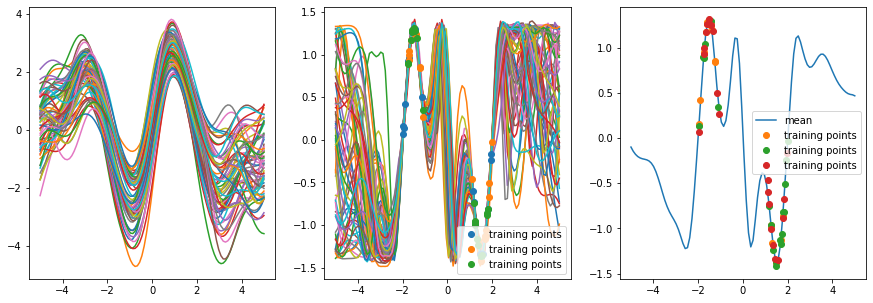

In [41]:
# print sampled lines
fig, ax = plt.subplots(1, model.n_hidden_layers+1, figsize=((model.n_hidden_layers+1)*5, 5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    for model_line in lines[:60]: # hidden outputs of each sampled model
        line = model_line[i]
        ax[i].plot(X_test[:,0], line.numpy()[:,0])
    # for model_line in lines[690:701]: # hidden outputs of each sampled model
    #     line = model_line[i]
    #     ax[i].plot(X_test.numpy()[:,0], line.numpy()[:,0], 'b')
for x, y in ds_train:
    ax[-2].plot(x[:,0], y[:,0], 'o', label='training points')
# for x, y in ds_test:
    # ax[-1].plot(x[:,0], y[:,0], '*', label='ground truth')
ax[-2].legend()

# compute the mean of the sampled lines
line_output = []
for model_line in lines[:64]:
    line_output.append(model_line[-1]) #the final layer
line_mean = tf.reduce_mean(tf.concat(line_output, axis=-1), axis=-1)
ax[-1].plot(X_test[:,0], line_mean.numpy(), label='mean')
for x, y in ds_train:
    ax[-1].plot(x[:,0], y[:,0], 'o', label='training points')
ax[-1].legend()
# fig.savefig('2layer-sin.png')

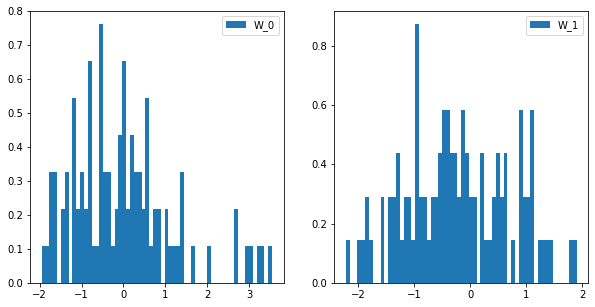

In [42]:
print_index = (25,0)
fig, ax = plt.subplots(1, model.n_hidden_layers, figsize=(model.n_hidden_layers*5,5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    W_print = []
    for W_model in W['W_'+str(i)][:]:
        W_print.append(W_model[print_index])
    ax[i].hist(W_print, bins=60, density=True, label='W_'+str(i))
    ax[i].legend()
# fig.savefig('2w-sin-2.png')

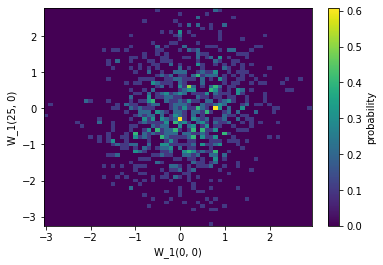

In [41]:
# try to show the correlation of two weights
print_index_1 = (0,0)
print_index_2 = (25,0)
W_print_1 = []
W_print_2 = []
for W_model in W['W_'+ str(1)][10:]:
    W_print_1.append(W_model[print_index_1])
    W_print_2.append(W_model[print_index_2])
plt.hist2d(W_print_1, W_print_2, bins=60, density=True)
plt.xlabel(f'W_1{print_index_1}')
plt.ylabel(f'W_1{print_index_2}')
cbar = plt.colorbar()
cbar.ax.set_ylabel('probability')
plt.savefig('correlation-sin-2.png')

# 2-layer DGPs (MCEM with Moving Windows)

In [5]:
# initialize the model
d_in = 1
d_out = 1
model = DemoRegressionDGP(d_in, d_out, n_hidden_layers=2, n_rf=100, n_gp=1,
                          likelihood=Gaussian(variance=0.01, trainable=True),
                          kernel_type_list=['RBF' for _ in range(2)], kernel_trainable=True,
                          random_fixed=True, input_cat=False)

In [6]:
# EM sampler settings
lr_mcmc_0 = 0.01
sampler_EM = MCEM_sampler_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                               lr_0=lr_mcmc_0, momentum_decay=0.9, resample_in_cycle_head=False,
                               start_sampling_epoch=100, epochs_per_cycle=100)

# Maximizer setttings
lr_maximizer = 0.01
optimizer = optimizers.Adam(learning_rate=lr_maximizer)
maximizer = MCEM_Q_maximizer_demo(model, num_training, optimizer)

# sampler settings after fixing hyper-params
lr_fixing_hyper_0 = 0.01
sampler_fixing_hyper = MCEM_sampler_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                                         lr_0=lr_fixing_hyper_0, momentum_decay=0.9, resample_in_cycle_head=False,
                                         start_sampling_epoch=300, epochs_per_cycle=100)

In [ ]:
# MCEM with Moving Windows settings and training
total_EM_steps = 100
_, _, lines, W = MCEM_windows_demo(sampler_EM, maximizer, sampler_fixing_hyper, total_EM_steps, ds_train, 
                              window_size=50,
                              num_samples_fixing_hyper=500,
                              print_epoch_cycle_EM=300, print_epoch_cycle_fixing=500)

############### EM step 1 of total 100 steps. E Step:  ###############


2022-08-26 07:50:24.257731: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-26 07:50:24.281270: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-26 07:50:24.847351: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-08-26 07:50:24.847407: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


#################### Sample No.1 at Epoch 199  lr = 7.51754214434186e-12 ####################
********************  End of Sampling  ********************
Number of sampled models: 1 
Test Log Likelihood of all sampled models: -0.3673102557659149
Test Root MSE of all sampled models: 0.1871340125799179
********************************************************************** 

********************  End of E step  ********************
Number of all sampled models in window: 1 
Test Log Likelihood of all models in window: -0.3673102557659149
Test Root MSE of all models in window: 0.1871340125799179

############### EM step 1 of total 100 steps, M Step:  ###############
**********************************************************************
Q function is 1.334572196006775 averaged by 1 samples.
********************************************************************** 

############### EM step 2 of total 100 steps. E Step:  ###############
#################### Sample No.1 at Epoch 199  lr = 7.51754

In [ ]:
model.Omega_hyperparams